In [17]:
import random
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import models, transforms

In [18]:
DATADIR = '/kaggle/input/ai-challenge/data/mnt/md0/projects/sami-hackathon/private/data/'
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
image_size = 224
train_transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std = [0.225, 0.225, 0.225])])
val_transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std = [0.225, 0.225, 0.225])])

df = pd.read_csv('/kaggle/input/ai-challenge/labels.csv')
df[df.file_name == 'image_4503.jpg']

,file_name,height,width,bbox,age,race,masked,skintone,emotion,gender
14777,image_4503.jpg,1024,1024,"[261.2020202020202, 147.9292929292934, 618.696...",Baby,Mongoloid,unmasked,light,Neutral,Female


In [19]:
image_paths = [DATADIR + path for path in list(df.file_name)]
bbox = [[float(i.strip()) for i in box.replace("[", "").replace("]", "").split(',')] for box in df.bbox]
age = list(df.age)
race = list(df.race)
masked = [1 if i == 'masked' else 0 for i in list(df.masked)]
skin = list(df.skintone)
emotion = list(df.emotion)
gender = list(df.gender)

In [21]:
def convert2dict(li):
    values, counts = np.unique(li, return_counts=True)
    result_dict = {value: count for value, count in zip(values, counts)}
    return result_dict

def plot_valcount(di, name):
    keys = list(di.keys())
    values = list(di.values())

    # Plot the figure
    fig, ax = plt.subplots()
    ax.bar(keys, values)
    ax.set_title(name)

    plt.show()


data_dict = {
    'Age': convert2dict(age),
    'Race': convert2dict(race),
    'Masked': convert2dict(masked),
    'Skin': convert2dict(skin),
    'Emotion': convert2dict(emotion),
    'Gender': convert2dict(gender),
}

data_dict['Emotion']

{'Anger': 319,
 'Disgust': 132,
 'Fear': 114,
 'Happiness': 9218,
 'Neutral': 4844,
 'Sadness': 380,
 'Surprise': 303}

In [ ]:
target_sample_size = 2000

def oversample_dataframe(df, target_size):
    repeat_times = -(-target_size // df.shape[0])  
    return pd.concat([df] * repeat_times, ignore_index=True).sample(target_size)


fear_df = oversample_dataframe(df[df.emotion == 'Fear'], target_sample_size)
disgust_df = oversample_dataframe(df[df.emotion == 'Disgust'], target_sample_size)
anger_df = oversample_dataframe(df[df.emotion == 'Anger'], target_sample_size)
sadness_df = oversample_dataframe(df[df.emotion == 'Sadness'], target_sample_size)
surprise_df = oversample_dataframe(df[df.emotion == 'Surprise'], target_sample_size)


happiness_df = df[df.emotion == 'Happiness'].sample(target_sample_size)
neutral_df = df[df.emotion == 'Neutral'].sample(target_sample_size)

fear_df.shape[0], disgust_df.shape[0], anger_df.shape[0], sadness_df.shape[0], surprise_df.shape[0], neutral_df.shape[0], happiness_df.shape[0]


target_sample_size = 2000

def oversample_dataframe(df, target_size):
    repeat_times = -(-target_size // df.shape[0])  
    return pd.concat([df] * repeat_times, ignore_index=True).sample(target_size)


fear_df = oversample_dataframe(df[df.emotion == 'Fear'], target_sample_size)
disgust_df = oversample_dataframe(df[df.emotion == 'Disgust'], target_sample_size)
anger_df = oversample_dataframe(df[df.emotion == 'Anger'], target_sample_size)
sadness_df = oversample_dataframe(df[df.emotion == 'Sadness'], target_sample_size)
surprise_df = oversample_dataframe(df[df.emotion == 'Surprise'], target_sample_size)

happiness_df = df[df.emotion == 'Happiness'].sample(target_sample_size)
neutral_df = df[df.emotion == 'Neutral'].sample(target_sample_size)

fear_df.shape[0], disgust_df.shape[0], anger_df.shape[0], sadness_df.shape[0], surprise_df.shape[0], neutral_df.shape[0], happiness_df.shape[0]


In [86]:
from math import ceil
def get_coordinate(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return (x1,y1,x2,y2)

def get_crop_face(img, box):
    x1,y1,x2,y2 = get_coordinate(box)
    x1,y1,x2,y2 = ceil(x1), ceil(y1), ceil(x2), ceil(y2)
    return img[y1:y2, x1:x2, :]

In [87]:
def shuffle_with_permutation(lst, permutation):
        combined = sorted(zip(lst, permutation), key=lambda x: x[1])
        shuffled_list = [item[0] for item in combined]
        return shuffled_list

In [88]:
def process_emotion_label(label):
    if (label=='Happiness'):
        return 0
    elif (label=='Neutral'):                 
        return 1
    elif (label=='Surprise'):
        return 2
    elif (label=='Sadness'):
        return 3
    elif (label=='Anger'):
        return 4
    elif (label =='Disgust'):
        return 5
    else:
        return 6   #Fear

class Emotion_Dataset(Dataset):
    def __init__(self, transform):
        super().__init__()
        image_paths, bbox, emotion = [], [], []
        
        for i in range(happiness_df.shape[0]):
            image_paths.append(DATADIR + happiness_df.iloc[i]['file_name'])
            bbox.append(happiness_df.iloc[i]['bbox'])
            emotion.append(process_emotion_label(happiness_df.iloc[i]['emotion']))

        for i in range(neutral_df.shape[0]):
            image_paths.append(DATADIR + neutral_df.iloc[i]['file_name'])
            bbox.append(neutral_df.iloc[i]['bbox'])
            emotion.append(process_emotion_label(neutral_df.iloc[i]['emotion']))
            
        for i in range(surprise_df.shape[0]):
            image_paths.append(DATADIR + surprise_df.iloc[i]['file_name'])
            bbox.append(surprise_df.iloc[i]['bbox'])
            emotion.append(process_emotion_label(surprise_df.iloc[i]['emotion']))
            
        for i in range(sadness_df.shape[0]):
            image_paths.append(DATADIR + sadness_df.iloc[i]['file_name'])
            bbox.append(sadness_df.iloc[i]['bbox'])
            emotion.append(process_emotion_label(sadness_df.iloc[i]['emotion']))
            
        for i in range(anger_df.shape[0]):
            image_paths.append(DATADIR + anger_df.iloc[i]['file_name'])
            bbox.append(anger_df.iloc[i]['bbox'])
            emotion.append(process_emotion_label(anger_df.iloc[i]['emotion']))
        
        for i in range(disgust_df.shape[0]):
            image_paths.append(DATADIR + disgust_df.iloc[i]['file_name'])
            bbox.append(disgust_df.iloc[i]['bbox'])
            emotion.append(process_emotion_label(disgust_df.iloc[i]['emotion']))
            
        exclude = []
        for i in range(fear_df.shape[0]):
            id = random.randint(0, fear_df.shape[0] - 1)
            while id in exclude:
                id = random.randint(0, fear_df.shape[0] - 1)
            exclude.append(id)
            image_paths.append(DATADIR + fear_df.iloc[id]['file_name'])
            bbox.append(fear_df.iloc[id]['bbox'])
            emotion.append(process_emotion_label(fear_df.iloc[id]['emotion']))
        
        idx = [i for i in range(len(image_paths))]
        random.shuffle(idx)
        self.image_paths = shuffle_with_permutation(image_paths, idx)
        self.bbox = shuffle_with_permutation(bbox, idx)
        self.emotion = shuffle_with_permutation(emotion, idx)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        path = self.image_paths[index]
        image = np.array(Image.open(path))
        box = self.bbox[index]
        box = [float(i.strip()) for i in box.replace("[", "").replace("]", "").split(',')]
        crop_img = get_crop_face(image, box)
        face = Image.fromarray(crop_img)
        emotion = self.emotion[index]
        face = self.transform(face)
        return face, emotion

emotion_data = Emotion_Dataset(train_transform)

In [89]:
face, emotion = emotion_data[10]
face , emotion

(tensor([[[-1.9115, -1.7198, -1.3364,  ...,  1.4523,  1.4523,  1.5046],
          [-1.6850, -1.6675, -1.3712,  ...,  1.4697,  1.4174,  1.4523],
          [-1.9464, -1.5630, -1.2667,  ...,  1.5569,  1.4871,  1.4871],
          ...,
          [ 0.4763,  0.5285,  0.5285,  ...,  1.9229,  1.9403,  1.9752],
          [ 0.4937,  0.5111,  0.5111,  ...,  1.9054,  1.9577,  1.9403],
          [ 0.4763,  0.4937,  0.4937,  ...,  1.9229,  1.9403,  1.9752]],
 
         [[-1.7827, -1.6084, -1.2249,  ...,  0.8317,  0.8492,  0.9189],
          [-1.5212, -1.5386, -1.2946,  ...,  0.8666,  0.7969,  0.8317],
          [-1.7129, -1.4689, -1.2424,  ...,  0.9886,  0.8840,  0.8317],
          ...,
          [ 0.5703,  0.6226,  0.6400,  ...,  1.9123,  1.9820,  2.0866],
          [ 0.5529,  0.6051,  0.6226,  ...,  1.9472,  2.0169,  2.1041],
          [ 0.5006,  0.5006,  0.4657,  ...,  1.9646,  2.0518,  2.1215]],
 
         [[-1.5430, -1.3861, -1.0027,  ...,  0.8622,  0.8797,  0.9668],
          [-1.2816, -1.2990,

In [90]:
class EmotionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = torch.load('/kaggle/input/dradata/backbone.pt', map_location=device)
        self.pool = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(7, 7)),
                                  nn.Flatten())
        self.fc = nn.Sequential(nn.Linear(in_features=25088, out_features=4096, bias=True),
                                nn.ReLU(inplace=True),
                                nn.Dropout())
        self.fc.load_state_dict = torch.load('/kaggle/input/dradata/fc.pth', map_location=device)
        self.emotioncls = nn.Linear(in_features=4096, out_features=7, bias=False)
        
    def forward(self, x):
        out = self.pool(self.backbone(x))
        return self.emotioncls(self.fc(out))

emotionmodel = EmotionModel()
emotionmodel = emotionmodel.to(device)
for p in emotionmodel.backbone.parameters():
    p.requires_grad = False

In [91]:
def get_dataloaders(ds, lengths=[0.8, 0.2], batch_size=32, seed=42):
    train_set, val_set = random_split(ds, lengths=lengths, generator=torch.Generator().manual_seed(seed))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

train_loader, val_loader = get_dataloaders(emotion_data)

In [92]:
def model_step(batch, model, loss_func, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x).squeeze()
    loss = loss_func(y_hat, y)
    return loss, y_hat, y

def optimizer_step(optimizer, scaler, loss):
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

def evaluation(model, loader, loss_func, scheduler, epoch, device, stage='Val'):
    model.eval()
    total, total_loss, total_acc = 0, 0, 0
    pbar = tqdm(loader)
    with torch.no_grad():
        for batch in pbar:
            loss, y_hat, y = model_step(batch, model, loss_func, device)
            total += len(y)
            total_loss += loss.item()
            total_acc += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
            pbar.set_description(f"Epoch {epoch} {stage} | Loss = {total_loss/total:.4f} | Acc = {total_acc*100/total:.2f}")
        scheduler.step(total_loss/total)
    return total_loss/total

def train_epoch(model, train_loader, loss_func, optimizer, scaler, epoch, device):
    model.train()
    pbar = tqdm(train_loader)
    total, total_loss, total_acc = 0, 0, 0
    for batch in pbar:
        loss, y_hat, y = model_step(batch, model, loss_func, device)
        optimizer_step(optimizer, scaler, loss)
        total += len(y)
        total_loss += loss.item()
        total_acc += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        pbar.set_description(f"Epoch {epoch} Train | Loss = {total_loss/total:.4f} | Acc = {total_acc*100/total:.2f}")
    return total_loss/total

def train(model, train_loader, val_loader, loss_func, optimizer, scaler,
          scheduler, max_epochs=10, device=device, early_stop=False):
    for epoch in range(max_epochs):
        ## train loop
        train_epoch(model, train_loader, loss_func, optimizer, scaler, epoch, device)
        ## val loop
        val_loss = evaluation(model, val_loader, loss_func, scheduler, epoch, device)

In [93]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=emotionmodel.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [94]:
train(emotionmodel, train_loader, val_loader, loss_fn, optimizer, scaler,
      scheduler, max_epochs=4, device=device)

Epoch 0 Train | Loss = 0.0360 | Acc = 58.50: 100%|██████████| 350/350 [07:54<00:00,  1.36s/it]
Epoch 0 Val | Loss = 0.0215 | Acc = 76.21: 100%|██████████| 88/88 [01:55<00:00,  1.31s/it]
Epoch 1 Train | Loss = 0.0156 | Acc = 83.12: 100%|██████████| 350/350 [07:53<00:00,  1.35s/it]
Epoch 1 Val | Loss = 0.0127 | Acc = 85.86: 100%|██████████| 88/88 [01:59<00:00,  1.35s/it]
Epoch 2 Train | Loss = 0.0099 | Acc = 88.85: 100%|██████████| 350/350 [08:01<00:00,  1.38s/it]
Epoch 2 Val | Loss = 0.0124 | Acc = 87.21: 100%|██████████| 88/88 [01:55<00:00,  1.31s/it]
Epoch 3 Train | Loss = 0.0072 | Acc = 92.06: 100%|██████████| 350/350 [07:50<00:00,  1.34s/it]
Epoch 3 Val | Loss = 0.0122 | Acc = 88.25: 100%|██████████| 88/88 [01:54<00:00,  1.30s/it]


In [95]:
def emotion_inference(
    model: torch.nn.Module,
    image_path: str,
    box, 
    image_size = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device):
    
    emotion_labels = {
        0: 'Happiness',
        1: 'Neutral',
        2: 'Surprise',
        3: 'Sadness',
        4: 'Anger',
        5: 'Disgust',
        6: 'Fear'
    }
    
    img = plt.imread(image_path)
    face = Image.fromarray(get_crop_face(img, box))
    
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([transforms.Resize(image_size),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                   std=[0.229, 0.224, 0.225])])

    model.eval()
    with torch.inference_mode():
        transformed_image = image_transform(face).unsqueeze(dim=0)
        logits = model(transformed_image.to(device))
        probabilities = torch.softmax(logits, dim=1).squeeze()
        pred_label_index = probabilities.argmax().item()
        label = emotion_labels[pred_label_index]
    
    plt.figure()
    plt.imshow(face)
    plt.title(f"Pred: {label} ({probabilities[pred_label_index]:.2f})")
    plt.axis(False)
    plt.show()
    
    return label


In [136]:
torch.save(emotionmodel.emotioncls.state_dict(), '/kaggle/working/emotion.pth')
print('Save success')

Save success


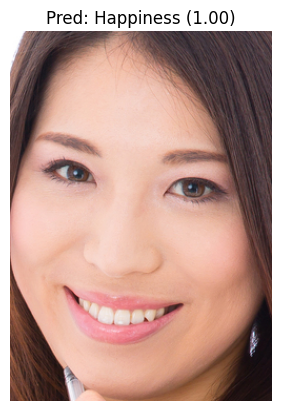

'Happiness'

In [133]:
id =8

emotion_inference(emotionmodel, image_path=image_paths[id], box=bbox[id])
